In [1]:
from galfind import (
    Instrument,
    Photometry,
    Photometry_rest,
    config,
    useful_funcs_austind,
    Euclid, Spitzer, CFHT, Subaru,
    NISP,
    MegaCam,
    HSC,
    VIS,
    IRAC,
    Multiple_Filter,
    SED_obs,
    Catalogue_Creator,
    EAZY,
    
)
import h5py as h5
from galfind.selection import Completeness
from galfind.Catalogue import phot_property_from_fits
from galfind import useful_funcs_austind as funcs
import itertools
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import astropy.units as u
from astropy.io import fits
from astropy.table import Table, Row, hstack, vstack
from typing import NoReturn

Reading GALFIND config file from: /nvme/scratch/work/tharvey/galfind/galfind/../configs/galfind_config.ini


INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


Setup filters - do it in stages to avoid confusion over filter names.

In [2]:
filterset_mc = Multiple_Filter.from_instrument('MegaCam', excl_bands=['CFHT/MegaCam.g',
                                                                      'CFHT/MegaCam.r', 
                                                                      'CFHT/MegaCam.i', 
                                                                      'CFHT/MegaCam.z', 
                                                                      'CFHT/MegaCam.Y', 
                                                                      'CFHT/MegaCam.J', 
                                                                      'CFHT/MegaCam.gri',
                                                                      'CFHT/MegaCam.H'])    

filterset_hsc = Multiple_Filter.from_instrument('HSC')

filterset = Multiple_Filter.from_instruments(['NISP', 'VIS', 'IRAC'], excl_bands=['Spitzer/IRAC.I3', 'Spitzer/IRAC.I4'])
filterset = filterset + filterset_mc + filterset_hsc       

Plot transmission 

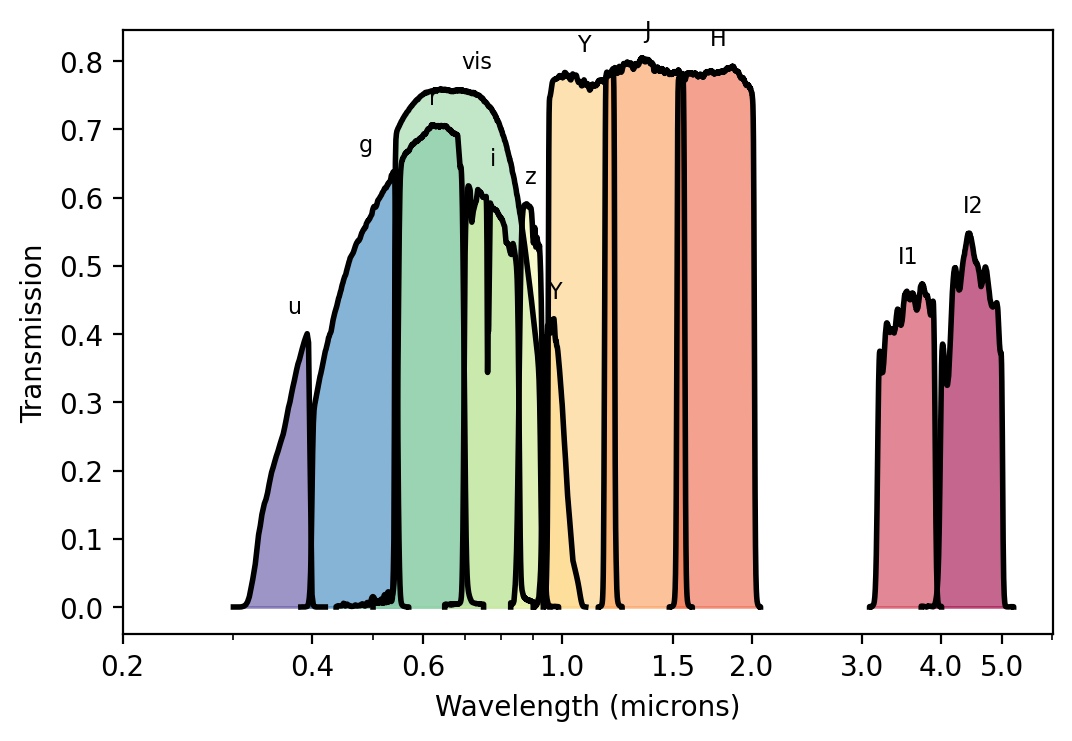

In [3]:
fig, ax = plt.subplots(dpi=200)
filterset.plot(ax=ax)
ax.set_xlabel('Wavelength (microns)')
ax.set_ylabel('Transmission')   
ax.set_xscale('log')
ax.set_xticks([0.2, 0.4, 0.6, 1, 1.5, 2, 3, 4, 5])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
plt.show()

Process spectra and save photometry

In [11]:
folder = '/raid/scratch/data/JAGUAR/Full_Spectra'
out_folder = '/nvme/scratch/work/tharvey/catalogs/' 
skip = False 
realization = 1 # realisation
redshift_bins = [(0.2, 1), (1, 1.5), (1.5, 2), (2, 3), (3, 4), (4, 5), (5, 15)]
filenames = [f'{folder}/JADES_SF_mock_r{realization}_v1.2_spec_5A_30um_z_{str(z1).replace(".", "p")}_{str(z2).replace(".", "p")}.fits' for z1, z2 in redshift_bins]

out_filename = f'{out_folder}/JADES_SF_mock_r{realization}_v1.2_{filterset.instrument_name}_phot.fits'
out_colnames = [f'{filter.instrument_name}_{filter.band_name}_fnu' for filter in filterset.filters]
out_colnames=['ID', 'redshift'] + out_colnames

filename_range = {}
if not skip:
    rows = []
    for file in filenames:
        hdu = fits.open(file)
        wav = hdu[2].data # Angstrom
        table = hdu[3].data
        ids = table['id']
        redshifts = table['redshift']
        filename_range[(ids[0], ids[-1])] = file
        nrows = hdu[1].shape[0]
        '''
        for i in tqdm(range(nrows), desc=f'Processing spectra from {file}'):
            flux = hdu[1].section[i, :] / (1+redshifts[i]) # convert from rest-frame to observed-frame
            sed = SED_obs(redshifts[i], wav, flux, wav_units=u.AA, mag_units=u.erg/u.s/u.cm**2/u.AA)
            mock_phot = sed.create_mock_photometryometryometryometry(filterset=filterset, min_flux_pc_err=0)
            flux = mock_phot.flux.to(u.nJy)
            row = (ids[i], redshifts[i]) + tuple(flux.value)
            rows.append(row)
            
        output_table = Table(rows = rows, names=out_colnames)
        output_table.write(out_filename, format='fits', overwrite=True)
                '''


In [12]:
filename_range

{(1,
  44829): '/raid/scratch/data/JAGUAR/Full_Spectra/JADES_SF_mock_r1_v1.2_spec_5A_30um_z_0p2_1.fits',
 (44830,
  81779): '/raid/scratch/data/JAGUAR/Full_Spectra/JADES_SF_mock_r1_v1.2_spec_5A_30um_z_1_1p5.fits',
 (81780,
  115980): '/raid/scratch/data/JAGUAR/Full_Spectra/JADES_SF_mock_r1_v1.2_spec_5A_30um_z_1p5_2.fits',
 (115981,
  172661): '/raid/scratch/data/JAGUAR/Full_Spectra/JADES_SF_mock_r1_v1.2_spec_5A_30um_z_2_3.fits',
 (172662,
  216247): '/raid/scratch/data/JAGUAR/Full_Spectra/JADES_SF_mock_r1_v1.2_spec_5A_30um_z_3_4.fits',
 (216248,
  248165): '/raid/scratch/data/JAGUAR/Full_Spectra/JADES_SF_mock_r1_v1.2_spec_5A_30um_z_4_5.fits',
 (248166,
  302515): '/raid/scratch/data/JAGUAR/Full_Spectra/JADES_SF_mock_r1_v1.2_spec_5A_30um_z_5_15.fits'}

open file to check it

In [32]:
table = Table.read(out_filename)
# add dummy RA and DEC columns

#table['RA'] = np.random.uniform(0, 360, len(table))
#table['DEC'] = np.random.uniform(-90, 90, len(table))

scale_factor = 200
flux_columns = [col for col in table.colnames if 'fnu' in col]

for col in flux_columns:
    table[col] = table[col] * scale_factor
    

table.write(out_filename.replace('.fits', f'_fnu_{scale_factor}x.fits'), format='fits', overwrite=True)

In [11]:
survey = 'Euclid-Deep'
version = 'v_sim'
aper_diams = [0.32] * u.arcsec

depths = [26] + [28] * len(filterset.band_names[1:])
depths = np.array(depths) #* u.ABmag


In [12]:
def jaguar_phot_labels(
    filterset: Multiple_Filter, 
    aper_diams: u.Quantity, 
    **kwargs
):
    assert "min_flux_pc_err" in kwargs.keys(), "min_flux_pc_err must be provided"
    phot_labels = { aper_diam * aper_diams.unit: [
                f'{filt.instrument_name}_{filt.band_name}_fnu'
                for filt in filterset
            ] for aper_diam in aper_diams.value
    }
    err_labels = {aper_diam * aper_diams.unit: [] for aper_diam in aper_diams.value}
    return phot_labels, err_labels

In [17]:
def load_jaguar_phot(
    cat: Table,
    phot_labels, #Dict[u.Quantity, List[str]],
    err_labels, #Dict[u.Quantity, List[str]],
    **kwargs
):
    assert phot_labels.keys() == err_labels.keys(), f"{phot_labels.keys()=} != {err_labels.keys()=}!"
    assert "ZP" in kwargs.keys(), "ZP not in kwargs!"
    phot = {aper_diam: funcs.flux_image_to_Jy(_phot, kwargs["ZP"]) for aper_diam, _phot \
        in phot_property_from_fits(cat, phot_labels, **kwargs).items()}
    if "incl_errs" in kwargs.keys():
        if not kwargs["incl_errs"]:
            phot_err = {aper_diam: np.array(list(itertools.repeat(None, len(cat)))) for aper_diam in phot_labels.keys()}
            print(phot_err)
            return phot, phot_err
    phot_err = {aper_diam: funcs.flux_image_to_Jy(_phot_err, kwargs["ZP"]) for aper_diam, _phot_err \
        in phot_property_from_fits(cat, err_labels, **kwargs).items()}
    return phot, phot_err

In [19]:
def load_depth_func(catalog, depth_labels, depths, **kwargs):
    output = {}
    for key, label in depth_labels.items():
        output[key] = depths
        
    print(output)
    return output

    

def get_depth_labels(filterset, aper_diams):
    depth_labels = { aper_diam * aper_diams.unit: [
                f'{filt.instrument_name}_{filt.band_name}_fnu'
                for filt in filterset
            ] for aper_diam in aper_diams.value
    }

    return depth_labels



In [20]:
jaguar_cat_path = f"/nvme/scratch/work/tharvey/catalogs/JADES_SF_mock_r{str(int(realization))}_v1.2_MegaCam+HSC+VIS+NISP+IRAC_phot.fits"
jaguar_cat_creator = Catalogue_Creator(
    survey = f"JAGUAR-{survey}-r{str(int(realization))}",
    version = version,
    cat_path = jaguar_cat_path,
    filterset = filterset,
    aper_diams = aper_diams, # not relevant in this case, but still required
    ID_label = "ID",
    skycoords_labels = {"RA": "RA", "DEC": "DEC"},
    get_phot_labels = jaguar_phot_labels,
    load_phot_func = load_jaguar_phot,
    load_phot_kwargs = {
        "ZP": u.nJy.to(u.ABmag),
        "min_flux_pc_err": 10.0,
        "incl_errs": False,
    },
    load_mask_func = None,
    load_depth_func = load_depth_func,
    get_depth_labels = get_depth_labels,
    load_depth_kwargs = {
        'depths':depths,
    },
    apply_gal_instr_mask = False,
    simulated = True,
)

jaguar_cat = jaguar_cat_creator()

INFO:galfind:Making JAGUAR-Euclid-Deep-r1 v_sim JADES_SF_mock_r1_v1.2_MegaCam+HSC+VIS+NISP+IRAC_phot catalogue!


{<Quantity 0.32 arcsec>: array([None, None, None, ..., None, None, None], dtype=object)}
{<Quantity 0.32 arcsec>: ['MegaCam_u_fnu', 'HSC_g_fnu', 'HSC_r_fnu', 'VIS_vis_fnu', 'HSC_i_fnu', 'HSC_z_fnu', 'HSC_Y_fnu', 'NISP_Y_fnu', 'NISP_J_fnu', 'NISP_H_fnu', 'IRAC_I1_fnu', 'IRAC_I2_fnu']}
{<Quantity 0.32 arcsec>: array([26, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28])}


TypeError: object of type 'numpy.int64' has no len()

In [ ]:
SED_fitter_arr = [
        EAZY({"templates": "fsps_larson", "lowz_zmax": 4.0}),
        EAZY({"templates": "fsps_larson", "lowz_zmax": None}),
    ]
# make 2D completeness grid from the Jaguar catalogue
completeness = Completeness.from_sim_cat(
    jaguar_cat,
    SED_fitter_arr = SED_fitter_arr,
    sampler = None,
    aper_diam = aper_diams[0],
    mode = "n_nearest",
    depth_region = "all",
    x_calculator = None,
    y_calculator = None,
    x_arr = None,
    y_arr = None,
)

NameError: name 'jaguar_cat' is not defined

In [16]:
table

ID,redshift,MegaCam_u_fnu,HSC_g_fnu,HSC_r_fnu,VIS_vis_fnu,HSC_i_fnu,HSC_z_fnu,HSC_Y_fnu,NISP_Y_fnu,NISP_J_fnu,NISP_H_fnu,IRAC_I1_fnu,IRAC_I2_fnu,RA,DEC
int32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,0.200103,8.650908806945104,15.277811579305622,16.323842901359626,17.2894690403071,16.537946678243976,17.007984484687853,16.87440932314353,16.699287057269206,15.570560383145068,14.855826020599551,6.421754656797376,5.233176124022795,51.78577997776806,37.88630253758386
2,0.200144,22.48771409475583,38.09925488802673,41.876198504863176,44.71202408305551,43.01717634220406,44.785532333117466,44.977532520772144,44.98341907067449,42.82041931045499,41.18375137677284,17.44084537269362,13.773311086571201,162.01134262039503,82.9193818756035
3,0.200162,55.52976806514718,90.233682630391,93.25542339149163,96.9923593856772,90.9620100624825,93.37219436531069,93.30844239159381,92.9737660581443,86.47963844804019,83.14010304220487,37.2294242080562,30.920445993677067,105.60500744556045,-18.390536958395927
4,0.200219,20.346089735976257,33.68744414677823,34.91991561726871,35.94518296687478,33.481357040393746,33.74914955795298,33.178536140739205,32.625173478510334,29.61286847590234,28.20469254639746,12.9013120519567,11.045858961545342,28.750215365571712,64.89699853742715
5,0.200321,29.840385354569676,49.977631159557355,50.30433724855205,52.15700741982329,48.9629813464487,48.999299641640796,47.59586547956396,46.19871223982196,41.80002813317973,39.464554653157464,21.482278542186723,21.760658944099866,19.72642657876868,40.85259206134748
6,0.200344,35.418910694668625,48.0673659880801,48.405117748464114,45.64818957352178,38.751977278984675,37.21394194622107,36.223014423062224,35.669698340326306,30.30168177953031,29.219435291508447,13.644979991841053,13.133727980090422,283.2103491485019,28.648339985809073
7,0.200381,55.38413082266569,89.99702804956175,93.0108439028086,96.73797899020747,90.72344524762894,93.1273082354766,93.06372433956975,92.72992723384786,86.25283024661437,82.92205519026534,37.13178316637168,30.839352195417618,120.48692017539652,71.11262287237349
8,0.2004,40.827469109584015,64.46527273752699,63.77307117260232,65.17153674221265,60.02389226361855,61.01044293779889,60.85625000668428,60.506242541355284,55.26210647853349,52.87064602163883,24.152097223431216,20.65831362251914,127.89830563709155,-51.031466387881295
9,0.200584,37.90686759540312,65.47189748803177,73.00564810187912,77.24682931591944,74.02297157197718,75.44890489430486,74.32999468362225,73.1307659550245,67.59073235329944,63.68489629229507,26.421028641229,21.359635344602673,216.8020112445618,-88.75711327118591


In [5]:
SED_fit_params = {'lowz_zmax': 4.0, 'templates': 'fsps_larson'}

eazy = EAZY(SED_fit_params=SED_fit_params)



In [29]:
for i in filterset:
    print(i.facility_name)

CFHT
Subaru
Subaru
Euclid
Subaru
Subaru
Subaru
Euclid
Euclid
Euclid
Spitzer
Spitzer


In [30]:
def write_filter_file(self, filterset: Multiple_Filter, filter_file: str) -> NoReturn:
        # Need to write a filterset file for EAZY
        # Two files one with list of filters and one with the transmission curves
        # format of list is

        # 1 len(transmission_curve) name1 lambda_c = pivot_wav
        # 2 len(transmission_curve) name2 lambda_c = pivot_wav

        # format of transmission curve is
        # len(transmission_curve) name1 lambda_c = pivot_wav
        # 1 0.1 0.0
        # 2 0.2 0.1
        # 3 0.3 0.2
        #...
        # len(transmission_curve) name1 lambda_c = pivot_wav
        # 1 0.1 0.0
        # 2 0.2 0.1

    with open(filter_file, 'w') as f:
        with open (f'{filter_file}.INFO', 'w') as f_info:
            
            for i, filt in enumerate(filterset):
                wav_cent = filt.properties["WavelengthEff"].to(u.Angstrom).value
                f_info.write(f'{i+1} {len(filt.trans)} {filt.facility_name}/{filt.instrument_name}.{filt.band_name} lambda_c= {wav_cent}\n')
                f.write(f' {len(filt.trans)} {filt.facility_name}/{filt.instrument_name}.{filt.band_name} lambda_c= {wav_cent}\n')

                for pos, (wav, trans) in enumerate(zip(filt.wav, filt.trans)):
                    f.write(f'{pos+1} {wav.to(u.Angstrom).value} {trans}\n')
                

In [31]:
write_filter_file('', filterset, 'filters.dat')

In [4]:
path = '/raid/scratch/work/tharvey/GALFIND_WORK/Catalogues/v_sim/MegaCam+HSC+VIS+NISP+IRAC/JAGUAR-Euclid_Deep-r1_10_fnu/(0.32)as/JAGUAR-Euclid_Deep-r1_10_fnu_v_sim_reg=all.fits'
cat = Table.read(path)
eazy = Table.read(path, hdu=2)

combined_table = hstack([cat, eazy])

combined_table.colnames

['ID',
 'redshift',
 'MegaCam_u_fnu',
 'HSC_g_fnu',
 'HSC_r_fnu',
 'VIS_vis_fnu',
 'HSC_i_fnu',
 'HSC_z_fnu',
 'HSC_Y_fnu',
 'NISP_Y_fnu',
 'NISP_J_fnu',
 'NISP_H_fnu',
 'IRAC_I1_fnu',
 'IRAC_I2_fnu',
 'RA',
 'DEC',
 'MegaCam.u_scattered',
 'MegaCam.u_err',
 'loc_depth_MegaCam.u',
 'HSC.g_scattered',
 'HSC.g_err',
 'loc_depth_HSC.g',
 'HSC.r_scattered',
 'HSC.r_err',
 'loc_depth_HSC.r',
 'VIS.vis_scattered',
 'VIS.vis_err',
 'loc_depth_VIS.vis',
 'HSC.i_scattered',
 'HSC.i_err',
 'loc_depth_HSC.i',
 'HSC.z_scattered',
 'HSC.z_err',
 'loc_depth_HSC.z',
 'HSC.Y_scattered',
 'HSC.Y_err',
 'loc_depth_HSC.Y',
 'NISP.Y_scattered',
 'NISP.Y_err',
 'loc_depth_NISP.Y',
 'NISP.J_scattered',
 'NISP.J_err',
 'loc_depth_NISP.J',
 'NISP.H_scattered',
 'NISP.H_err',
 'loc_depth_NISP.H',
 'IRAC.I1_scattered',
 'IRAC.I1_err',
 'loc_depth_IRAC.I1',
 'IRAC.I2_scattered',
 'IRAC.I2_err',
 'loc_depth_IRAC.I2',
 'IDENT',
 'zbest_fsps_larson_zmax=15.0',
 'zbest_16_fsps_larson_zmax=15.0',
 'zbest_84_fsps_lars

[0.11239279 0.10348171 0.10348171 0.10348171 0.10348171 0.10348171
 0.10348171 0.10348171 0.10348171 0.10348171 0.10348171 0.10348171] [0.11239279 0.10348171 0.10348171 0.10348171 0.10348171 0.10348171
 0.10348171 0.10348171 0.10348171 0.10348171 0.10348171 0.10348171]
(1, 44829)
(44830, 81779)
(81780, 115980)
23817
105597
1.845439
b'nJy'
b'Angstrom'
(302515, 2, 5994)


Text(0, 0.5, 'Flux (Jy)')

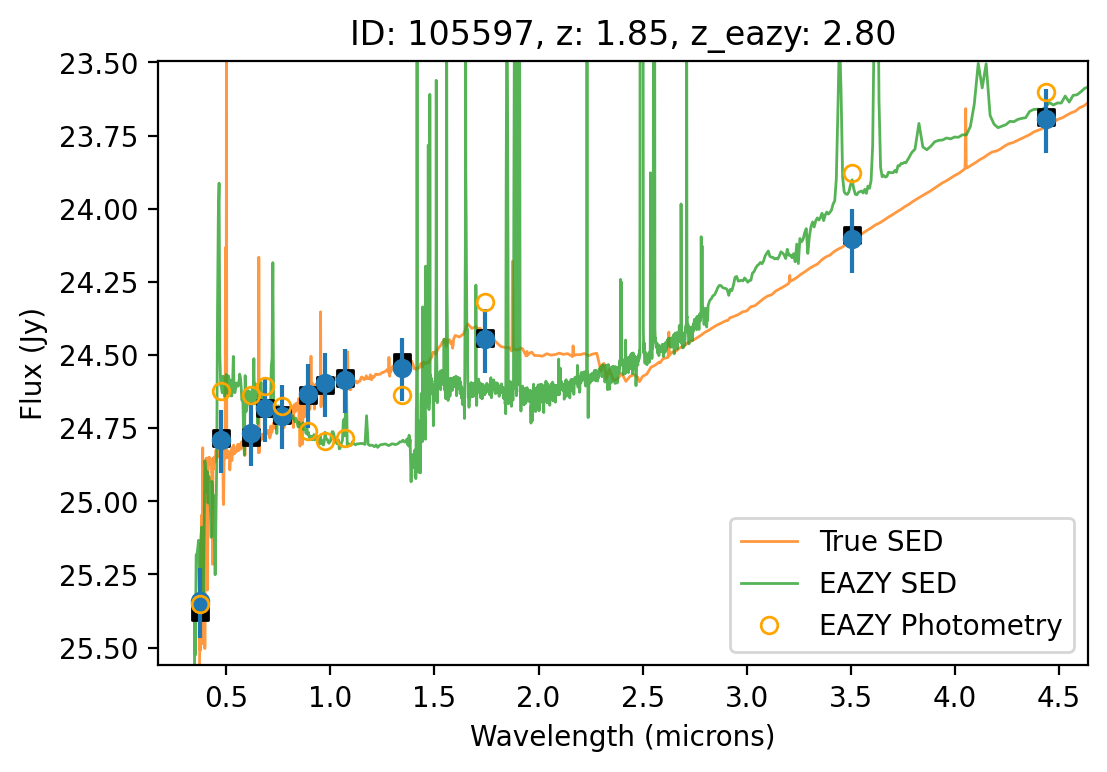

In [31]:
filter_names = [f'{filter.instrument_name}.{filter.band_name}' for filter in filterset]
filter_wavs = [filter.properties['WavelengthEff'].to(u.micron).value for filter in filterset]

row = 105596 #90410#133399#155019 # 1107 #
v = '_10_fnu'
fluxes = [combined_table[f'{filter_name}_scattered'][row] for filter_name in filter_names]
errs = [combined_table[f'{filter_name}_err'][row] for filter_name in filter_names]

original_fluxes = [combined_table[f'{filter_name.replace(".", "_")}_fnu'][row] for filter_name in filter_names] * u.nJy



fig, ax = plt.subplots(dpi=200)

gal_id = combined_table['ID'][row]
redshift = combined_table['redshift'][row]
ez = combined_table['zbest_fsps_larson_zmax=15.0'][row]

fluxes = np.array(fluxes) * u.Jy
errs = np.array(errs) * u.Jy

low_errs = np.abs(2.5 * np.log10(fluxes/(fluxes - errs)))
high_errs = np.abs(2.5 * np.log10(1 + errs/fluxes))

print(high_errs, high_errs)
errs = np.array([high_errs, low_errs])

ax.set_title(f'ID: {gal_id}, z: {redshift:.2f}, z_eazy: {ez:.2f} $\chi^2$: {combined_table["chi2_best_fsps_larson_zmax=15.0"][row]:.2f}')
ax.errorbar(filter_wavs, fluxes.to(u.ABmag).value, yerr=errs, fmt='o', zorder=10)

ax.scatter(filter_wavs, original_fluxes.to(u.ABmag).value, marker='s', color='black', zorder=5) 

# Plot the SED

for key in filename_range.keys():
    print(key)
    if key[0] <= gal_id <= key[1]:
        file = filename_range[key]
        i = gal_id - key[0] 
        print(i)
        break

hdu = fits.open(file)
wav = hdu[2].data * u.AA # Angstrom
table = hdu[3].data

print(table['id'][i])   
print(table['redshift'][i])

nrows = hdu[1].shape[0] * u.AA
flux = hdu[1].section[i, :] / (1+redshift)
flux = 10*flux * u.erg/u.s/u.cm**2/u.AA
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim()[::-1])

ax.plot(wav.to(u.micron), flux.to(u.ABmag, equivalencies=u.spectral_density(wav)), label='True SED', alpha=0.8, lw=1)


seds = f'/raid/scratch/work/tharvey/GALFIND_WORK/EAZY/output/MegaCam+HSC+VIS+NISP+IRAC/v_sim/JAGUAR-Euclid_Deep-r1{v}/JAGUAR-Euclid_Deep-r1{v}_v_sim_reg=all_0.32as_EAZY_fsps_larson_zmax=15.0_SEDs.h5'

with h5.File(seds, 'r') as f:
    wav = f['wav_flux_arr'][row, 0, :] * u.AA
    
    flux = f['wav_flux_arr'][row, 1, :] * u.nJy
    
    ax.plot(wav.to(u.micron), flux.to(u.ABmag, equivalencies=u.spectral_density(wav)), label='EAZY SED', alpha=0.8, lw=1)
    # convolve with filters
      
    mock_phot = SED_obs(redshift, wav.value, flux.value, wav_units=u.AA, mag_units=u.nJy).create_mock_photometry(filterset=filterset, min_flux_pc_err=0)
    flux = mock_phot.flux.to(u.nJy)
    ax.errorbar(filter_wavs, flux.to(u.ABmag).value, fmt='o', zorder=10, markeredgecolor='orange', markerfacecolor='none', label='EAZY Photometry')
    
ax.legend()

ax.set_xlabel('Wavelength (microns)')
ax.set_ylabel('Flux (Jy)')

In [27]:
min_flux_pc_err = 10

five_sig_depths = np.array([26] + [28] * len(filterset[1:])) * u.ABmag
five_sig_depths = five_sig_depths.to(u.nJy)
one_sig_depths = five_sig_depths / 5
one_sig_depths_Jy = one_sig_depths.to(u.Jy)
fluxes = [30, 29, 28, 27, 26, 25] * u.ABmag
fluxes = fluxes.to(u.Jy)

one_sig_depths_Jy

<Quantity [2.89087954e-08, 4.58173531e-09, 4.58173531e-09, 4.58173531e-09,
           4.58173531e-09, 4.58173531e-09, 4.58173531e-09, 4.58173531e-09,
           4.58173531e-09, 4.58173531e-09, 4.58173531e-09, 4.58173531e-09] Jy>

In [29]:
flux_errs = np.array(
            [
                depth
                if depth > flux * min_flux_pc_err / 100
                else flux * min_flux_pc_err / 100
                for flux, depth in zip(fluxes.value, one_sig_depths_Jy.value)
            ]
        ) * u.Jy

In [30]:
fluxes/flux_errs

<Quantity [ 0.12559432,  1.99053585,  5.        , 10.        , 10.        ,
           10.        ]>